In [8]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import seaborn as sns

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
sns.set(style='whitegrid')
sns.set_palette('deep', color_codes=True)
sns.set_context('poster', font_scale=1.5)

In [2]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [ ]:
importlib.reload(lf)

In [19]:
end = sun_rise_set['sunset'][0]
end = end.tz_localize('UTC').tz_convert('MST')
print(end)

2014-04-15 18:52:50.879341824-07:00


(-60.0, 60.0, -60.0, 60.0)

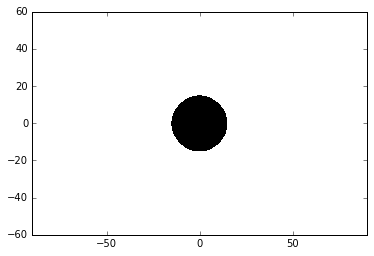

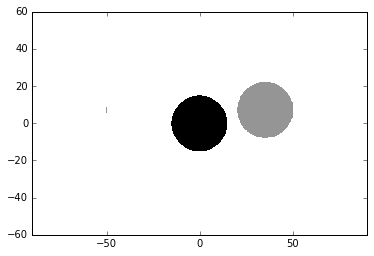

In [7]:
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
sun_rise_set = pv.solarposition.get_sun_rise_set_transit(
    time='2014-04-15', latitude=tus.latitude, longitude=tus.longitude)

start = sun_rise_set['sunrise'][0]
start = start.tz_localize('UTC').tz_convert('MST')
start = start + pd.Timedelta('20min')

end = sun_rise_set['sunset'][0]
end = end.tz_localize('UTC').tz_convert('MST')
end = end + pd.Timedelta('20min')

# start = '2014-04-15 6:00:00'
# end = '2014-04-15 8:00:00'
times = pd.date_range(start=start, end=end, freq='2min')
cloud_height = 2000 #meters

#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5*(2*np.pi)/360
goes15_elevation = 44.1*(2*np.pi)/360


solar_position = tus.get_solarposition(times)
x_correct, y_correct = lf.parallax_shift(cloud_height,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*2*np.pi/360,
                     solar_position['elevation'].values*2*np.pi/360)
temp = np.linspace(-50, 50, 400)
x, y = np.meshgrid(temp, temp)
circ = np.sqrt(x**2 + y**2)
circ[circ<=15] = 1
circ[circ>15] = 0
plt.figure()
plt.pcolormesh(x, y, circ, cmap='Greys')
plt.axis('equal')
# plt.axis('equal')
# plt.figure()
temp = np.roll(circ,
               (int(np.rint(y_correct[0]/250)), int(np.rint(x_correct[0]/250))),
               axis=(0, 1))*.5 + circ

plt.figure()
plt.pcolormesh(x, y, temp, cmap='Greys')
plt.axis('equal')

In [12]:
y_correct.size

389

In [18]:
for t in np.arange(x_correct.size):
    temp = np.roll(circ,
                   (int(np.rint(y_correct[t]/250)), -int(np.rint(x_correct[t]/250))),
                   axis=(0, 1))*.5 + circ
    temp = temp.clip(max=1)
    fig, ax = plt.subplots()
    ax.pcolormesh(x, y, temp, cmap='Greys')
    plt.axis('equal')
    plt.title('Time: ' + str(times[t].time()))
    plt.axis([-50, 50, -50, 50])
    ax.set(adjustable='box-forced', aspect='equal')
    plt.savefig('paralax_movie/zfig{0:04}.png'.format(t))
    plt.close('all')

In [ ]:
str(times[100].time())

In [ ]:
plt.figure()
plt.plot(x_correct/250)